## Установка и импорт библиотек

In [1]:
!pip install -q opencv-python
!pip install -q pyyaml
!pip install -q albumentations

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import os
import ast 
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
import albumentations as A
import zipfile



/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Загрузка и сводка по данным

In [5]:
# Базовые пути Kaggle
KAGGLE_DIR = 'укажите путь для временной рабочей области/specify the path for the temporary workspace'
INPUT_DIR = 'Укажите путь к исходному датасету/Specify the path to the source dataset'  # путь к исходному датасету

# Создаем все необходимые директории
DATASET_DIR = os.path.join(KAGGLE_DIR, 'dataset')  # для финального датасета (train/val/test)
TEMP_DIR = os.path.join(KAGGLE_DIR, 'temp_data')   # для промежуточных данных
ARCHIVE_DIR = os.path.join(KAGGLE_DIR, 'data_zip')  # для архива

# Создаем все директории
for dir_path in [DATASET_DIR, TEMP_DIR, ARCHIVE_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Проверяем создание директорий
print("Структура рабочих директорий:")
print(f"INPUT_DIR (исходные данные): {INPUT_DIR}")
print(f"TEMP_DIR (промежуточные данные): {TEMP_DIR}")
print(f"DATASET_DIR (финальный датасет): {DATASET_DIR}")
print(f"ARCHIVE_DIR (архив): {ARCHIVE_DIR}")

Структура рабочих директорий:
INPUT_DIR (исходные данные): /kaggle/input/waste-detection
TEMP_DIR (промежуточные данные): /kaggle/working/temp_data
DATASET_DIR (финальный датасет): /kaggle/working/dataset
ARCHIVE_DIR (архив): /kaggle/working/data_zip


In [6]:
# Загрузка  данных
train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

In [7]:
# Получение уникальных классов и их количества
unique_classes = train_df['category_id'].unique()
class_counts = train_df['category_id'].value_counts()

print("Уникальные классы пластиковых отходов:")
print(unique_classes)

print("\nКоличество объектов каждого класса:")
print(class_counts)
train_df.head()

Уникальные классы пластиковых отходов:
[ 4.  2. 10.  1. 13.  7.  9. 15. 11. 14.  3.  5. nan  6.  8. 12.]

Количество объектов каждого класса:
category_id
2.0     7310
1.0     4747
13.0    4553
4.0     3780
7.0     2530
14.0    2278
10.0    2123
15.0    1032
5.0      909
3.0      848
9.0      653
6.0      495
11.0     374
8.0      364
12.0     152
Name: count, dtype: int64


,file_name,bbox,category_id
0,000001.jpg,"[840.0, 0.0, 176.0, 124.0]",4.0
1,000001.jpg,"[612.0, 306.0, 383.0, 397.0]",2.0
2,000001.jpg,"[990.92, 551.0, 105.00000000000011, 186.0]",4.0
3,000002.jpg,"[1000.0, 614.0, 98.0, 178.0]",4.0
4,000002.jpg,"[605.0, 358.0, 402.0, 409.0]",2.0


train.csv: CSV-файл, содержащий разметку для обучения модели. Каждая строка включает:

* file_name: имя файла
* bbox: рамка в формате [x_left, y_top, width, height]
* category_id: класс объекта, присутствующего на изображнии
н


Также видим сильный дисбаланс классов, к нему вернемся чуть позже.иинии

In [8]:
test_df.head()

,file_name
0,000003.jpg
1,000006.jpg
2,000013.jpg
3,000016.jpg
4,000019.jpg


test.csv: Файл, содержащий имена изображений для тестирования. Эти изображения необходимо классифицировать с помощью разработанных моделей

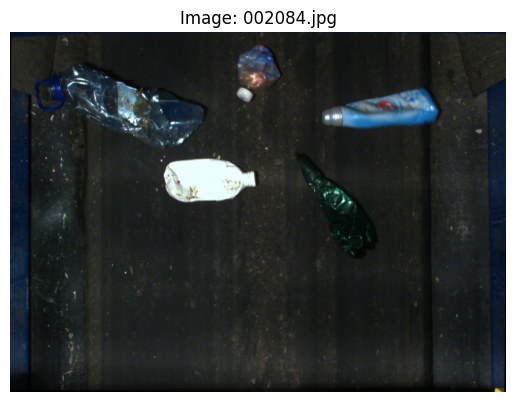

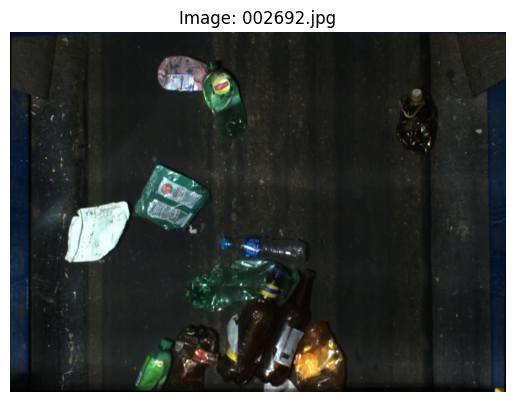

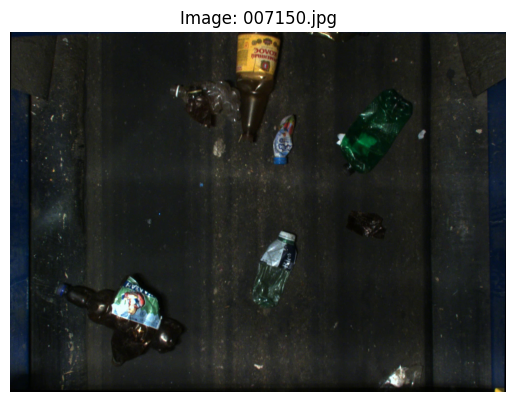

In [9]:
# Путь к папке с изображениями
image_directory = 'Укажите путь к папке с изображениями / Specify the path to the folder with images '

# Получение списка всех файлов в папке
all_images = os.listdir(image_directory)

# Выбор трех случайных изображений
random_images = random.sample(all_images, 3)

# Отображение каждого изображения
for image_name in random_images:
    image_path = os.path.join(image_directory, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертация цвета для корректного отображения в matplotlib
    plt.imshow(image)
    plt.title(f'Image: {image_name}')
    plt.axis('off')
    plt.show()



## Борьба с дисбалансом - применяем oversampling

In [10]:
# Анализ распределения классов
print("Уникальные классы пластиковых отходов:")
print(train_df['category_id'].unique())
print("\nКоличество объектов каждого класса:")
print(train_df['category_id'].value_counts())

Уникальные классы пластиковых отходов:
[ 4.  2. 10.  1. 13.  7.  9. 15. 11. 14.  3.  5. nan  6.  8. 12.]

Количество объектов каждого класса:
category_id
2.0     7310
1.0     4747
13.0    4553
4.0     3780
7.0     2530
14.0    2278
10.0    2123
15.0    1032
5.0      909
3.0      848
9.0      653
6.0      495
11.0     374
8.0      364
12.0     152
Name: count, dtype: int64


In [11]:
# Функции для oversampling и аугментации
def apply_light_augmentation(image):
    """
    Применяет легкие аугментации к изображению:
    - Случайное изменение яркости
    - Возможное небольшое размытие
    """
    # Случайное изменение яркости (±20%)
    brightness = random.uniform(0.8, 1.2)
    image = cv2.convertScaleAbs(image, alpha=brightness, beta=0)
    
     # С вероятностью 50% применяем легкое размытие
    if random.random() > 0.5:
        image = cv2.GaussianBlur(image, (3, 3), 0)
    
    # Случайное изменение контраста
    contrast = random.uniform(0.8, 1.2)
    mean = np.mean(image)
    image = cv2.convertScaleAbs((image - mean) * contrast + mean)
    
    return image

In [12]:
def apply_oversampling(df, input_images_dir, output_images_dir, threshold=1000):
    """
    Применяет oversampling и сохраняет полный датасет
    Аргументы:
        df: датафрейм с аннотациями
        input_images_dir: директория с исходными изображениями
        output_images_dir: директория для сохранения всего датасета
        threshold: пороговое значение для oversampling
    """
    print("Начинаем oversampling...")
    
    # Копируем оригинальные изображения
    print("\nКопируем оригинальные изображения...")
    for img_name in df['file_name'].unique():
        src_path = os.path.join(input_images_dir, img_name)
        dst_path = os.path.join(output_images_dir, img_name)
        if not os.path.exists(dst_path):
            shutil.copy2(src_path, dst_path)
    
    # Анализ датасета
    original_counts = df['category_id'].value_counts()
    print("\nПервоначальное распределение классов:")
    print(original_counts)
    
    problem_classes = original_counts[original_counts < threshold].index.tolist()
    print(f"\nКлассы с количеством объектов меньше {threshold}:")
    print(problem_classes)
    
    new_df = df.copy()
    
    for problem_class in problem_classes:
        current_count = len(df[df['category_id'] == problem_class])
        needed_copies = threshold - current_count
            
        print(f"\nДобавляем {needed_copies} копий для класса {problem_class} (было {current_count})")
        
        # Выбираем все изображения с нужным классом
        class_samples = df[df['category_id'] == problem_class]
        
        for i in range(needed_copies):
            # Выбираем случайную строку
            sample = class_samples.sample(n=1).iloc[0]
            
            # Читаем изображение
            img_path = os.path.join(input_images_dir, sample['file_name'])
            img = cv2.imread(img_path)
            
            # Применяем аугментацию
            augmented_img = apply_light_augmentation(img)
            
            # Создаем новое имя файла
            base_name = os.path.splitext(sample['file_name'])[0]
            new_name = f"{base_name}_aug_{i}.jpg"
            
            # Сохраняем аугментированное изображение
            new_path = os.path.join(output_images_dir, new_name)
            cv2.imwrite(new_path, augmented_img)
            
            # Создаем новую строку с теми же аннотациями
            new_row = sample.copy()
            new_row['file_name'] = new_name
            new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)
    
    # Перемешиваем датафрейм
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    
    print("\nНовое распределение классов:")
    print(new_df['category_id'].value_counts())
    
    return new_df

In [13]:
# Используем уже созданную директорию
train_df = apply_oversampling(
    df=train_df,
    input_images_dir=os.path.join(INPUT_DIR, 'images'),
    output_images_dir=TEMP_DIR,  # используем существующую директорию
    threshold=1000
)

# Сохраняем обновленный датафрейм в ту же директорию
train_df.to_csv(os.path.join(TEMP_DIR, 'augmented_train.csv'), index=False)

Начинаем oversampling...

Копируем оригинальные изображения...

Первоначальное распределение классов:
category_id
2.0     7310
1.0     4747
13.0    4553
4.0     3780
7.0     2530
14.0    2278
10.0    2123
15.0    1032
5.0      909
3.0      848
9.0      653
6.0      495
11.0     374
8.0      364
12.0     152
Name: count, dtype: int64

Классы с количеством объектов меньше 1000:
[5.0, 3.0, 9.0, 6.0, 11.0, 8.0, 12.0]

Добавляем 91 копий для класса 5.0 (было 909)

Добавляем 152 копий для класса 3.0 (было 848)

Добавляем 347 копий для класса 9.0 (было 653)

Добавляем 505 копий для класса 6.0 (было 495)

Добавляем 626 копий для класса 11.0 (было 374)

Добавляем 636 копий для класса 8.0 (было 364)

Добавляем 848 копий для класса 12.0 (было 152)

Новое распределение классов:
category_id
2.0     7310
1.0     4747
13.0    4553
4.0     3780
7.0     2530
14.0    2278
10.0    2123
15.0    1032
6.0     1000
9.0     1000
12.0    1000
8.0     1000
11.0    1000
5.0     1000
3.0     1000
Name: count, dty

## Создаем директории 

In [14]:
# Создаем необходимые поддиректории
for split in ['train', 'val', 'test']:
    for subdir in ['images', 'labels']:
        if split == 'test' and subdir == 'labels':
            continue
        path = os.path.join(DATASET_DIR, split, subdir)
        os.makedirs(path, exist_ok=True)

print("Созданная структура директорий:")
for path in Path(DATASET_DIR).rglob("*"):
    if path.is_dir():
        print(f"DIR: {path}")


Созданная структура директорий:
DIR: /kaggle/working/dataset/val
DIR: /kaggle/working/dataset/train
DIR: /kaggle/working/dataset/test
DIR: /kaggle/working/dataset/val/labels
DIR: /kaggle/working/dataset/val/images
DIR: /kaggle/working/dataset/train/labels
DIR: /kaggle/working/dataset/train/images
DIR: /kaggle/working/dataset/test/images


## Трансформация координат 

In [15]:
# Создаем трансформацию для конвертации bbox
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
    A.GaussianBlur(blur_limit=(3, 3), p=0.3),
    A.HorizontalFlip(p=0.5)
], bbox_params=A.BboxParams(
    format='coco',
    label_fields=['class_labels']
))

## Обработка файлов

In [16]:
def process_file(filename, split, df):
    """
    Обрабатывает один файл для указанного split (train/val)
    Аргументы:
        filename: имя файла для обработки
        split: 'train' или 'val'
        df: датафрейм с аннотациями
    """
    try:
        # Проверяем пути
        src_img_path = os.path.join(TEMP_DIR, filename)
        dst_img_path = os.path.join(DATASET_DIR, split, 'images', filename)
        
        # Если файл уже существует, пропускаем
        if os.path.exists(dst_img_path):
            return
            
        # Проверяем аннотации
        file_annotations = df[df['file_name'] == filename]
        if file_annotations.empty:
            print(f"Не найдены аннотации для файла {filename}")
            return
        
        # Копируем изображение
        shutil.copy2(src_img_path, dst_img_path)
        
        # Читаем изображение для размеров
        image = cv2.imread(src_img_path)
        if image is None:
            print(f"Не удается прочитать изображение: {src_img_path}")
            return
            
        height, width = image.shape[:2]
        
        # Создаем файл с метками
        label_filename = filename.replace('.jpg', '.txt')
        label_path = os.path.join(DATASET_DIR, split, 'labels', label_filename)
        
        # Записываем метки в формате YOLO
        with open(label_path, 'w') as f:
            for _, row in file_annotations.iterrows():
                try:
                    bbox = ast.literal_eval(row['bbox']) if isinstance(row['bbox'], str) else row['bbox']
                    if isinstance(bbox, (list, tuple)) and len(bbox) == 4:
                        # COCO формат: [x, y, width, height]
                        x, y, w, h = bbox
                        
                        # Конвертируем в YOLO формат
                        x_center = (x + w/2) / width
                        y_center = (y + h/2) / height
                        w = w / width
                        h = h / height
                        
                        # Проверяем координаты
                        if 0 <= x_center <= 1 and 0 <= y_center <= 1 and w > 0 and h > 0:
                            f.write(f"{int(row['category_id']) - 1} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")
                        
                except Exception as e:
                    print(f"Ошибка обработки bbox для файла {filename}: {str(e)}")
                    
    except Exception as e:
        print(f"Ошибка обработки файла {filename}: {str(e)}")

## Разделение и обработка данных

In [17]:
train_files = train_df['file_name'].unique()
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

print(f"Количество файлов для обучения: {len(train_files)}")
print(f"Количество файлов для валидации: {len(val_files)}")

Количество файлов для обучения: 7364
Количество файлов для валидации: 1841


In [18]:
# Обрабатываем тренировочные данные
for filename in train_files:
    process_file(filename, 'train', train_df)

In [19]:
# Обрабатываем валидационные данные
for filename in val_files:
    process_file(filename, 'val', train_df)

In [20]:
# Копируем тестовые изображения
for filename in test_df['file_name'].unique():
    src_img_path = os.path.join(INPUT_DIR, 'images', filename)
    dst_img_path = os.path.join(DATASET_DIR, 'test', 'images', filename)
    shutil.copy2(src_img_path, dst_img_path)

## Упаковка в архив

In [21]:
# Создаем архив в отдельной директории
archive_name = 'renue-data'
archive_path = os.path.join(ARCHIVE_DIR, f'{archive_name}.zip')

# Архивируем только финальный датасет
shutil.make_archive(os.path.join(ARCHIVE_DIR, archive_name), 'zip', DATASET_DIR)
# Выводим информацию
print(f"Архив создан: {archive_path}")
print(f"Размер архива: {os.path.getsize(archive_path) / (1024*1024):.2f} МБ")

Архив создан: /kaggle/working/data_zip/renue-data.zip
Размер архива: 6026.46 МБ


In [22]:
# Очистка всех директорий, кроме архива
try:
    print("\nОчистка рабочих директорий...")
    
    # Список директорий для очистки
    dirs_to_clean = [TEMP_DIR, DATASET_DIR]
    
    for dir_path in dirs_to_clean:
        if os.path.exists(dir_path):
            print(f"Удаление {os.path.basename(dir_path)}...")
            shutil.rmtree(dir_path)
            print(f"Директория успешно удалена: {dir_path}")
    
    # Проверяем финальный размер архива
    archive_path = os.path.join(ARCHIVE_DIR, 'prepared_data.zip')
    if os.path.exists(archive_path):
        archive_size = os.path.getsize(archive_path) / (1024*1024)
        print(f"\nФинальный архив: {archive_path}")
        print(f"Размер архива: {archive_size:.2f} МБ")
    else:
        print("\nОШИБКА: Архив не найден!")

except Exception as e:
    print(f"Ошибка при очистке директорий: {str(e)}")


Очистка рабочих директорий...
Удаление temp_data...
Директория успешно удалена: /kaggle/working/temp_data
Удаление dataset...
Директория успешно удалена: /kaggle/working/dataset

ОШИБКА: Архив не найден!
